# Sujet 4 : Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques

On commence par déclarer les bibliothèques utilisés :

Note : `urllib.request` n'y est pas car elle n'est utilisée que dans le cas où on doit télécharger les données.

In [1]:
%matplotlib inline
import re
import gzip
import time
import pandas
import io
import os
import datetime
import matplotlib.pyplot as plt
import statsmodels.api

## Connexion courte à l'intérieur d'un campus

On commence par récupérer les données à étudier :

In [2]:
def telecharger_fichier_si_necessaire(data_url):

    # Extrait le nom du fichier à partir de l'URL
    data_file = data_url[(data_url.rindex("/")+1):]

    # Vérification de l'extention
    if data_file[-7:] != ".log.gz":
        raise Exception("Le fichier nom de fichier "+data_file+" ne finit pas par \".log.gz\" !")

    if not os.access(data_file, os.R_OK):
        import urllib.request
        print("Les données n'existent pas en local, on les télécharges.")
        urllib.request.urlretrieve(data_url, data_file)
        if os.access(data_file, os.R_OK):
            print("Fichier récupéré.")
        else:
            raise Exception("Le fichier n'a pas pu être récupéré !")
    else:
        print("Les données sont déjà présentes en local.")

telecharger_fichier_si_necessaire("http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz")

Les données sont déjà présentes en local.


On définit la fonction qui va lire chaque ligne pour en extraire les données. La ligne retournée sera formatée en CSV.

Comme ce qui nous intéresse est le temps mis pour un aller-retour (ou "ping") il faut impérativement que celle ci soit présente pour que la ligne soit reconnue, pour les lignes dans ce cas on retournera `Ǹone`.

Si la ligne est totalement illisible on soulèvera une exception afin d'avertir l'utilisateur qu'il y a des lignes dont le format est illisible par le programme. Ceci est préférable au fait de retourner `Ǹone` car si c'était le cas on risquerait de masquer des données utiles, par exemple si `ping` avait retourné des données en secondes plutôt qu'en millisecondes.

In [3]:
extractDataFromLineRegExp = re.compile("^\[([0-9\.]+)\] ([0-9]+) bytes[^:]*: icmp_seq=[0-9]+ ttl=[0-9]+( time=([0-9\.]+) ms)?$")
def extractDataFromLine(line):
    match = extractDataFromLineRegExp.match(line)
    if match and match[4]:
        return match[1]+","+match[2]+","+match[4]+"\n"
    elif match:
        return None
    else:
        raise Exception("La ligne \""+line+"\" n'est pas dans le format attendu.")

# Quelques essais
print(extractDataFromLine("[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms"))  # Le retour à la ligne est inclus dans ce qui est retourné
print(extractDataFromLine("[1421773281.582445] 13 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50"))
print()
try:
    print(extractDataFromLine("[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 s"))
    print("On devrait avoir une exception ici.")
except Exception as e:
    print("Exception (attendue) : "+e.args[0])

1421761682.052172,665,22.5

None

Exception (attendue) : La ligne "[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 s" n'est pas dans le format attendu.


Lit les données du fichier, utilise la fonction `extractDataFromLine` définit précédemment pour extraire les données et les placer dans une variables `csv_data` qui contiendra les données au format CSV.

J'ai dans un premier temps essayé de ne pas passer par une variable intermédiaire et ajouter les données directement dans le DataFrame mais c'était extrêmement lent. Il aurait aussi été possible de passer par un fichier intermédiaire. En cas de données plus imposantes cela aurait été nécessaire.

In [4]:
def convertit_fichier_en_csv(data_file):
    nb = 0
    start_time = time.time()
    data = '"date","size","time"\n' # La première ligne du CSV à les noms de champs
    with gzip.open(data_file, 'rb') as file:
        for line in file:
            line_data = extractDataFromLine(line.decode('utf-8').strip())
            if line_data:
                data += line_data
            nb += 1

    print ("Lu %d lignes en %.3f sec" % (nb, time.time() - start_time))
    return data

csv_data = convertit_fichier_en_csv("liglab2.log.gz")

Lu 44413 lignes en 0.190 sec


Traduit le tableau du format CSV en temps que DataFrame pandas. Comme on lit depuis le contenu d'une variable on utilise `io.StringIO` qui permet de lire une variable comme on lit un fichier.

In [5]:
raw_data = pandas.read_csv(io.StringIO(csv_data))
# csv_data = None  # Libère la mémoire
raw_data

date  size   time
0      1.421762e+09   665  22.50
1      1.421762e+09  1373  21.20
2      1.421762e+09   262  21.20
3      1.421762e+09  1107  23.30
4      1.421762e+09  1128   1.41
5      1.421762e+09   489  21.90
6      1.421762e+09  1759  78.70
7      1.421762e+09  1146  25.10
8      1.421762e+09   884  24.00
9      1.421762e+09  1422  19.50
10     1.421762e+09  1180  18.00
11     1.421762e+09   999  18.80
12     1.421762e+09  1020  24.30
13     1.421762e+09    71   3.45
14     1.421762e+09    34   5.85
15     1.421762e+09  1843   2.31
16     1.421762e+09   407   1.14
17     1.421762e+09   356   1.10
18     1.421762e+09  1511   2.18
19     1.421762e+09   587   1.27
20     1.421762e+09   809   1.33
21     1.421762e+09  1364   1.51
22     1.421762e+09  1153   1.44
23     1.421762e+09   853   1.30
24     1.421762e+09  1510   2.17
25     1.421762e+09   123   1.21
26     1.421762e+09  1966   2.20
27     1.421762e+09   933   1.34
28     1.421762e+09   922   1.42
29     1.421762e+09    24   1.12
...             ...   ...    ...
44006  1.421771e+09  1772  28.80
44007  1.421771e+09    41   1.14
44008  1.421771e+09  1944   2.32
44009  1.421771e+09   400   1.98
44010  1.421771e+09   226   3.01
44011  1.421771e+09   466   7.45
44012  1.421771e+09   350  13.50
44013  1.421771e+09  1829  45.90
44014  1.421771e+09  1954  58.50
44015  1.421771e+09  1074   1.45
44016  1.421771e+09    46   1.11
44017  1.421771e+09  1844   2.26
44018  1.421771e+09   645   1.24
44019  1.421771e+09   444   1.25
44020  1.421771e+09  1940   2.46
44021  1.421771e+09  1411   1.47
44022  1.421771e+09    49   1.21
44023  1.421771e+09   420   1.55
44024  1.421771e+09   227   1.22
44025  1.421771e+09   947   1.34
44026  1.421771e+09  1960   2.43
44027  1.421771e+09   531   1.19
44028  1.421771e+09   374   1.14
44029  1.421771e+09  1503   2.19
44030  1.421771e+09   572   1.29
44031  1.421771e+09  1338   1.47
44032  1.421771e+09  1515   7.02
44033  1.421771e+09  1875   2.33
44034  1.421771e+09  1006   1.61
44035  1.421771e+09  1273   1.35

[44036 rows x 3 columns]

### Premiers constats sur les données

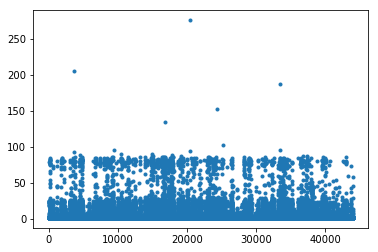

In [6]:
raw_data['time'].plot(style='.')

On remarque quelques points avec un délai nettement plus importante que d'habitude.

Sinon en histogramme (attention l'échelle est logarithmique) :

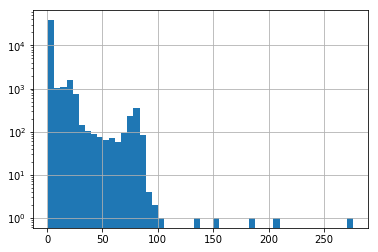

In [7]:
raw_data['time'].hist(log=True, bins=50)

On remarque bien que la majorité des requêtes ont une réponse quasi immédiate. Beaucoup ont une réponse dans les 30 ms. Les durées de 70~80 ms semble être surprenamment courantes. Il n'y a que très peu de réponses dont la durée est supérieure à 90ms.

### Y a t'il une variabilité par heure ou par jour de la semaine ?

Comme il s'agit d'un campus on peut s'attendre à une variabilité des performances due aux activités. On peut supposer que le réseau soit plus chargé durant les jours ouvrées et aux heures de travail.

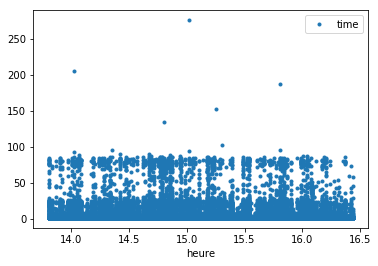

In [8]:
def timestamp_vers_heure(timestamp):
    str_time = datetime.datetime.fromtimestamp(timestamp).strftime('%H:%M:%S')
    parts = str_time.split(':')
    return float(parts[0]) + (float(parts[1]) / 60.0) + (float(parts[0]) / 3600.0)

raw_data['heure'] = [timestamp_vers_heure(ts) for ts in raw_data['date']]
raw_data.plot(x='heure', y='time', style='.')

Il semblerait que seuls quelques heures dans l'après midi soit présentes. Les données ont été prises juste sur quelques heures ou plusieurs jours aux mêmes heures ? Il aurait fallu vérifier la durée des observations.

In [9]:
print(datetime.datetime.fromtimestamp(raw_data['date'].min()).strftime('%d/%m/%Y %H:%M:%S'))
print(datetime.datetime.fromtimestamp(raw_data['date'].max()).strftime('%d/%m/%Y %H:%M:%S'))

20/01/2015 13:48:02
20/01/2015 16:26:26


Les données ne sont présentes que pour une petite tranche horaire durant une seule journée. Il s'agit d'un mardi donc jour ouvré mais je ne penses pas que l'on puisse faire des statistiques liés à la variation de charge réseau. Les données ne montrent pas de fortes variations qui pourrait être expliquée par un usage très différent du réseau à un moment donné.

### Temps de transmission en fonction de la taille des messages et effet de la segmentation.

On va commencer par une petite visualisation graphique du phénomène :

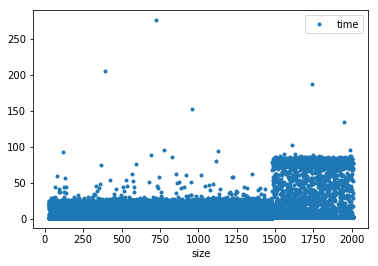

In [10]:
raw_data.plot(x='size', y='time', style='.')

On voit bien les effets de la segmentation du paquet qui commence un peu avant 1500. C'est visiblement ce qui à été à l'origine de la bizarrerie que j'avais constaté et qui fait qu'il y a une augmentation du nombre de requêtes autour de 70~80 ms par rapport à des durées légèrement plus brèves.

Il faut donc savoir si on veut tester la transmission avec ou sans la capacité des routeurs à segmenter les paquets.

Le fait que la limite soit proche de 1500 laisse penser que le réseau est basé sur de l'Ethernet sans jumbo frames ce qui est cohérent avec ce que l'on trouve habituellement dans les universités. Le MTU de l'Ethernet est de 1500 auquel il faut soustraire la taille de l'entête IPv4 qui est de 20 octets (sauf options mais peu probable). L'entête du paquet ICMP (8 octets) est normalement inclus dans le retour de la commande `ping` donc on ne le retranchera pas.

Il aurait été intéressant de tester le MTU grâce aux commandes suivantes :
```
ping -4 -M do -s 1472 lig-publig.imag.fr
ping -4 -M do -s 1473 lig-publig.imag.fr
```
Si le MTU est bien de 1500 (incluant l'entête IPv4) la première commande devrait réussir mais la seconde échouer. Je précise que contrairement à la sortie de la commande, le paramètre "-s" n'inclus pas les 8 octets de l'entête ICMP.

### Cas sans segmentation (size <= 1480) 

On sélectionne donc les entrées de 1480 octets ou moins :

In [11]:
non_frag = raw_data[raw_data['size'] <= 1480]
non_frag

date  size   time      heure
0      1.421762e+09   665  22.50  13.803611
1      1.421762e+09  1373  21.20  13.803611
2      1.421762e+09   262  21.20  13.803611
3      1.421762e+09  1107  23.30  13.803611
4      1.421762e+09  1128   1.41  13.803611
5      1.421762e+09   489  21.90  13.803611
7      1.421762e+09  1146  25.10  13.803611
8      1.421762e+09   884  24.00  13.803611
9      1.421762e+09  1422  19.50  13.803611
10     1.421762e+09  1180  18.00  13.803611
11     1.421762e+09   999  18.80  13.803611
12     1.421762e+09  1020  24.30  13.803611
13     1.421762e+09    71   3.45  13.803611
14     1.421762e+09    34   5.85  13.803611
16     1.421762e+09   407   1.14  13.803611
17     1.421762e+09   356   1.10  13.803611
19     1.421762e+09   587   1.27  13.803611
20     1.421762e+09   809   1.33  13.803611
21     1.421762e+09  1364   1.51  13.803611
22     1.421762e+09  1153   1.44  13.803611
23     1.421762e+09   853   1.30  13.803611
25     1.421762e+09   123   1.21  13.803611
27     1.421762e+09   933   1.34  13.803611
28     1.421762e+09   922   1.42  13.803611
29     1.421762e+09    24   1.12  13.803611
31     1.421762e+09  1122   1.61  13.803611
32     1.421762e+09   995   1.44  13.803611
33     1.421762e+09  1348   1.46  13.803611
34     1.421762e+09   760   1.30  13.803611
35     1.421762e+09  1076   1.41  13.803611
...             ...   ...    ...        ...
43988  1.421771e+09    67   1.04  16.437778
43991  1.421771e+09   267   1.25  16.437778
43992  1.421771e+09  1169   1.30  16.437778
43993  1.421771e+09  1165   1.33  16.437778
43994  1.421771e+09  1272   1.36  16.437778
43997  1.421771e+09   832   1.33  16.437778
43998  1.421771e+09  1439   1.41  16.437778
44001  1.421771e+09   978   1.44  16.437778
44002  1.421771e+09  1097   1.33  16.437778
44003  1.421771e+09   855   1.46  16.437778
44007  1.421771e+09    41   1.14  16.437778
44009  1.421771e+09   400   1.98  16.437778
44010  1.421771e+09   226   3.01  16.437778
44011  1.421771e+09   466   7.45  16.437778
44012  1.421771e+09   350  13.50  16.437778
44015  1.421771e+09  1074   1.45  16.437778
44016  1.421771e+09    46   1.11  16.437778
44018  1.421771e+09   645   1.24  16.437778
44019  1.421771e+09   444   1.25  16.437778
44021  1.421771e+09  1411   1.47  16.437778
44022  1.421771e+09    49   1.21  16.437778
44023  1.421771e+09   420   1.55  16.437778
44024  1.421771e+09   227   1.22  16.437778
44025  1.421771e+09   947   1.34  16.437778
44027  1.421771e+09   531   1.19  16.437778
44028  1.421771e+09   374   1.14  16.437778
44030  1.421771e+09   572   1.29  16.437778
44031  1.421771e+09  1338   1.47  16.437778
44034  1.421771e+09  1006   1.61  16.437778
44035  1.421771e+09  1273   1.35  16.437778

[32667 rows x 4 columns]

On regarde les données sélectionnées sous forme de graphique :

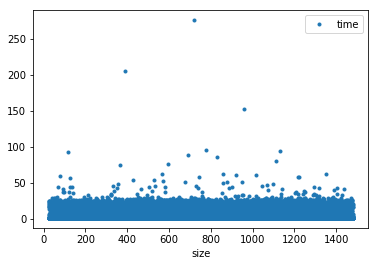

In [12]:
non_frag.plot(x='size', y='time', style='.')

Et l'histogramme de répartition des durées (attention échelle logarithmique) :

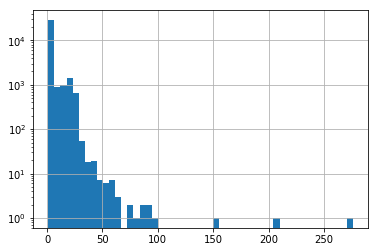

In [13]:
non_frag['time'].hist(log=True, bins=50)

On remarque bien l'absence du pic vers 70~80 ms que l'on avait avant.

On tente une régression linéaire :

In [14]:
size_stat = non_frag['size']
size_stat = statsmodels.api.add_constant(size_stat)
model = statsmodels.api.OLS(non_frag['time'], size_stat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.75
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           0.000123
Time:                        17:48:17   Log-Likelihood:            -1.0715e+05
No. Observations:               32667   AIC:                         2.143e+05
Df Residuals:                   32665   BIC:                         2.143e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2757      0.072     45.301      0.000       3.134       3.417
size           0.0003    8.5e-05      3.841      0.000       0.000       0.000
==============================================================================
Omnibus:                    41906.256   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         31002700.511
Skew:                           6.581   Prob(JB):                         0.00
Kurtosis:                     153.346   Cond. No.                     1.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On regarde l'évolution de la durée en fonction de la taille du paquet (attention, échelle logarithmique) :

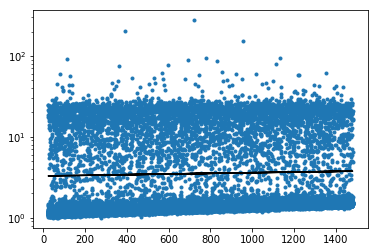

In [15]:
def affiche_points_et_regression(points, model):
    plt.scatter(points['size'], points['time'], marker=".")
    plt.plot(points['size'], model.predict(), color='black')
    plt.yscale('log')
    plt.show()

affiche_points_et_regression(non_frag, model)

Cela semble être cohérent, calcule les paramètres L et C de la connexion :

In [16]:
def print_details_connexion(model):
    print("La latence est de L=%fs (soit %.3fms)" % (model.params.const / 1000, model.params.const))

    temps_en_ms_pour_1octet = model.params.tolist()[1]
    temps_en_s_pour_1octet = temps_en_ms_pour_1octet / 1000.0
    nombre_octets_dans_1s = 1.0 / temps_en_s_pour_1octet
    print("La capacité est de C=%.0f octets/s (soit %.2f Mo/s ou %.2f Mbps)" % (nombre_octets_dans_1s, nombre_octets_dans_1s / 1000000, nombre_octets_dans_1s / 1000000 * 8))

print_details_connexion(model)

La latence est de L=0.003276s (soit 3.276ms)
La capacité est de C=3064515 octets/s (soit 3.06 Mo/s ou 24.52 Mbps)


### Cas avec segmentation (size > 1480) 

On sélectionne les entrées de plus de 1480 octets et affiche l'histogramme de répartition des durées (attention échelle logarithmique) :

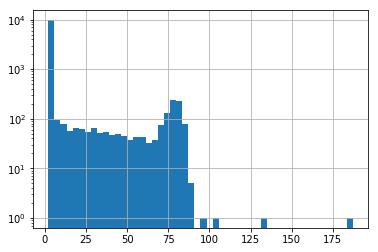

In [17]:
avec_frag = raw_data[raw_data['size'] > 1480]
avec_frag['time'].hist(log=True, bins=50)

Le fameux pic vers 70~80 ms réapparaît bien.

Calcule la régression :

In [18]:
size_stat = avec_frag['size']
size_stat = statsmodels.api.add_constant(size_stat)
model = statsmodels.api.OLS(avec_frag['time'], size_stat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.050
Date:                Fri, 12 Jun 2020   Prob (F-statistic):             0.0442
Time:                        17:48:18   Log-Likelihood:                -50605.
No. Observations:               11369   AIC:                         1.012e+05
Df Residuals:                   11367   BIC:                         1.012e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2898      2.244      2.357      0.018       0.891       9.689
size           0.0026      0.001      2.012      0.044     6.7e-05       0.005
==============================================================================
Omnibus:                     6230.343   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33724.913
Skew:                           2.764   Prob(JB):                         0.00
Kurtosis:                       9.374   Cond. No.                     2.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On regarde l'évolution de la durée en fonction de la taille du paquet (attention, échelle logarithmique) :

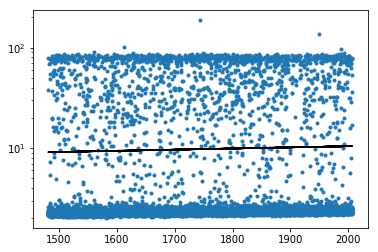

In [19]:
affiche_points_et_regression(avec_frag, model)

Cela semble être cohérent, calcule les paramètres L et C de la connexion :

In [20]:
print_details_connexion(model)

La latence est de L=0.005290s (soit 5.290ms)
La capacité est de C=387760 octets/s (soit 0.39 Mo/s ou 3.10 Mbps)


C'est nettement moins performant !

## Connexion vers un site Web éloigné assez populaire

Tout d'abord, récupération des données. Le fichier est au même format donc on peut utiliser les mêmes fonctions que précédemment :

In [21]:
telecharger_fichier_si_necessaire("http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz")
csv_data = convertit_fichier_en_csv("stackoverflow.log.gz")
raw_data = pandas.read_csv(io.StringIO(csv_data))

Les données sont déjà présentes en local.
Lu 6887 lignes en 0.044 sec


Regarde si, comme le site proche, les données ont été récupérées sur une courte période :

In [22]:
print(datetime.datetime.fromtimestamp(raw_data['date'].min()).strftime('%d/%m/%Y %H:%M:%S'))
print(datetime.datetime.fromtimestamp(raw_data['date'].max()).strftime('%d/%m/%Y %H:%M:%S'))

20/01/2015 16:26:43
20/01/2015 17:04:20


C'est le cas, on regarde tout de même si il semble y avoir une variation notable des performances :

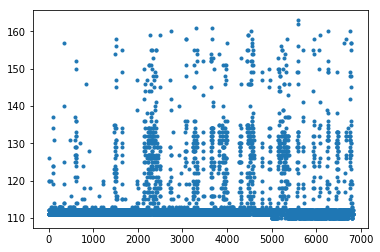

In [23]:
raw_data['time'].plot(style='.')

On voit que le temps d'attente est parfois plus long. C'est attendu dans le cas d'un site distant et/ou plus chargé. C'est assez curieux mais il semble que le délai minimum diminue très légèrement avec le temps. Peut être un réseau moins chargé ? La commande `ping` ne donne que 3 chiffres significatifs. C'est peut être la cause d'un effet d'arrondi.

Pourrait t'il y avoir un lien entre l'heure et la taille des paquets envoyés (ils sont sensés être aléatoire) ?

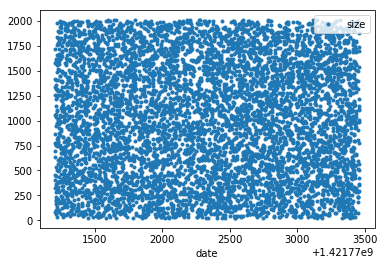

In [24]:
raw_data.plot(x='date', y='size', style='.')

Visuellement il n'y a rien qui indique qu'il y ait un biais à ce sujet.

On va donc voir le temps de transmission en fonction de la taille :

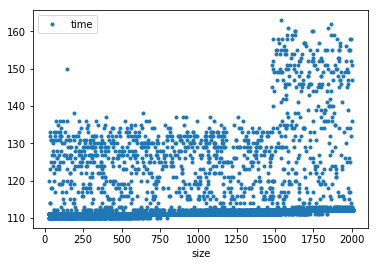

In [25]:
raw_data.plot(x='size', y='time', style='.')

### Cas sans segmentation (size <= 1480) 

On sélectionne donc les entrées de 1480 octets ou moins :

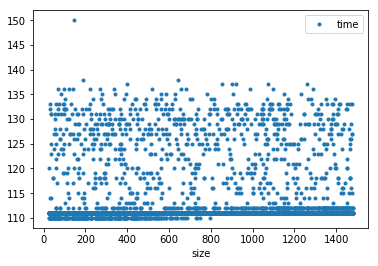

In [26]:
non_frag = raw_data[raw_data['size'] <= 1480]
non_frag.plot(x='size', y='time', style='.')

Déjà bonne nouvelle le MTU ne semble pas être différent car vu la variété de réseaux traversé il serait compliqué de donner une valeur sûre.

On peut donc essayer de faire une régression :

In [27]:
size_stat = non_frag['size']
size_stat = statsmodels.api.add_constant(size_stat)
model = statsmodels.api.OLS(non_frag['time'], size_stat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05442
Date:                Fri, 12 Jun 2020   Prob (F-statistic):              0.816
Time:                        17:48:20   Log-Likelihood:                -15946.
No. Observations:                5015   AIC:                         3.190e+04
Df Residuals:                    5013   BIC:                         3.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.2275      0.165    684.253      0.000     112.903     113.552
size        4.521e-05      0.000      0.233      0.816      -0.000       0.000
==============================================================================
Omnibus:                     2447.857   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10432.526
Skew:                           2.500   Prob(JB):                         0.00
Kurtosis:                       7.993   Cond. No.                     1.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On regarde l'évolution de la durée en fonction de la taille du paquet (attention, échelle logarithmique) :

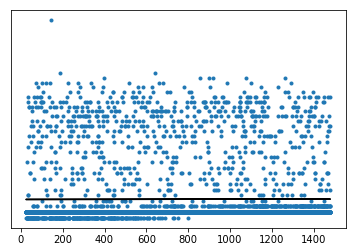

In [28]:
affiche_points_et_regression(non_frag, model)

**Il y a un problème, les données ne semble pas assez précises car la courbe de régression est trop plate.**

Au vue du nuage de points il semble que cela soit dû aux valeurs bruités qui sont très nombreuses.

La mesure ne pourrait toutefois pas être très précise à cause des arrondis fait par la commande `ping`. Dans l'exemple précédent un octet supplémentaire augmentait le temps de transmission en moyenne de 0.0003 ms (coef size visible dans le modèle de régression). Passer de 0 à 1480 octets augmente le délai de moins de 1ms.

Il faut voir si on ne peut pas retirer les valeurs trop déviantes :

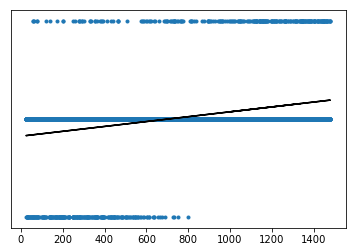

In [29]:
med_time = non_frag['time'].median()
decal_permis = 1
data_clean = non_frag[((med_time - decal_permis) <= non_frag['time']) & (non_frag['time'] <= (med_time + decal_permis))]

size_stat = data_clean['size']
size_stat = statsmodels.api.add_constant(size_stat)
model = statsmodels.api.OLS(data_clean['time'], size_stat).fit()

affiche_points_et_regression(data_clean, model)

On retrouve quelque chose de cohérent :

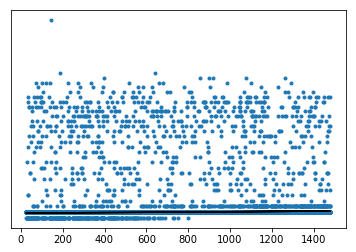

In [30]:
def affiche_points_et_regression_data_clean(data_uncleaned, data_cleaned, model):
    plt.scatter(data_uncleaned['size'], data_uncleaned['time'], marker=".")
    plt.plot(data_cleaned['size'], model.predict(), color='black')
    plt.yscale('log')
    plt.show()

affiche_points_et_regression_data_clean(non_frag, data_clean, model)

In [31]:
print_details_connexion(model)

La latence est de L=0.110821s (soit 110.821ms)
La capacité est de C=4025780 octets/s (soit 4.03 Mo/s ou 32.21 Mbps)


### Cas avec segmentation (size > 1480) 

On sélectionne maintenant les entrées de plus de 1480 octets et affiche l'histogramme de répartition des durées (attention échelle logarithmique) :

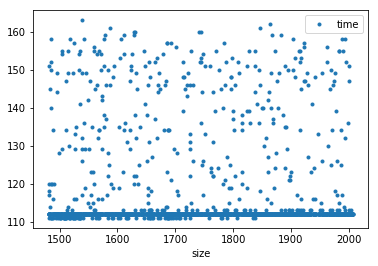

In [32]:
avec_frag = raw_data[raw_data['size'] > 1480]
avec_frag.plot(x='size', y='time', style='.')

Là aussi les données sont bien trop bruités ! On va les nettoyer et faire la régression avec la même méthode que précédemment :

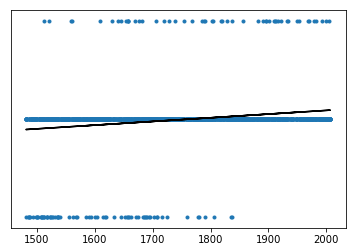

In [33]:
med_time = avec_frag['time'].median()
decal_permis = 1
data_clean = avec_frag[((med_time - decal_permis) <= avec_frag['time']) & (avec_frag['time'] <= (med_time + decal_permis))]

size_stat = data_clean['size']
size_stat = statsmodels.api.add_constant(size_stat)
model = statsmodels.api.OLS(data_clean['time'], size_stat).fit()

affiche_points_et_regression(data_clean, model)

Ce qui visualisé avec les autres points donne :

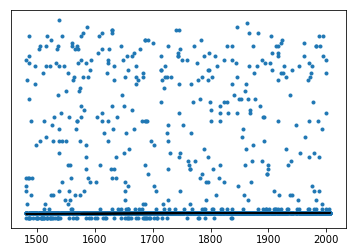

In [34]:
affiche_points_et_regression_data_clean(avec_frag, data_clean, model)

On peut estimer les paramètres de la connexion :

In [35]:
print_details_connexion(model)

La latence est de L=0.111333s (soit 111.333ms)
La capacité est de C=2663910 octets/s (soit 2.66 Mo/s ou 21.31 Mbps)


## Conclusion

Les paramètres de latence et de capacité dans chaque cas sont les suivants :

| Distance | Segmentation |  Latence | Capacité |
|:-:|:-:|:-:|:-:|
| Courte | Non | 3.3 ms| 3.06 Mo/s |
| Courte | Oui | 5.3 ms | 0.39 Mo/s |
| Longue | Non | 110.8 ms | 4.03 Mo/s |
| Longue | Oui | 111.3 ms | 2.66 Mo/s |

Les valeurs de capacité semble être particulièrement imprécises.